## Cодержание:
* [Импорт библиотек](#1)
* [Загрузка и изучение данных](#2)
* [Базовый анализ данных](#3)
* [EDA](#4)

## Импорт библиотек <a class="anchor" id="1"></a>

In [277]:
# pip install noisereduce
# pip install librosa

In [9]:
import tarfile

import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import sys

import librosa
import librosa.display

from IPython.display import Audio
import noisereduce as nr

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder


import torch
import torchaudio
from torch.utils.data import Dataset, DataLoader



import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)


RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Загрузка и изучение данных <a class="anchor" id="2"></a>

Датасет Dusha by Sber


В исходной неагрегированной таблице данных содержатся следующие поля:

audio_path — путь к аудиофайлу;

annotator_id — уникальный идентификатор разметчика, который оценивает эмоцию; 

annotator_emo — эмоция, которую указал разметчик;

golden_emo — эмоция контрольного задания;

speaker_text — текст, который произнёс диктор;

speaker_emo — эмоция, которую выражал диктор («заказанная» эмоция для разметчика-диктора из первой группы для семплов из Crowd, None для семплов из Podcasts);

source_id — уникальный идентификатор диктора или подкаста.

In [298]:
# !wget https://n-ws-q0bez.s3pd12.sbercloud.ru/b-ws-q0bez-jpv/dusha/crowd.tar

Read files

In [299]:
def load_data(path, columns_to_drop=['hash_id', 'source_id']):
    df = pd.read_json(path, lines=True).drop(columns=columns_to_drop)
    df['audio_path'] = df['audio_path'].apply(lambda x: x.split('/')[1])
    df = df[df['annotator_emo'] != 'other']
    #df = df[df['duration'] <= 5.0]
    return df

In [300]:
tar_file_path = 'crowd.tar'

with tarfile.open(tar_file_path, 'r') as tar:
    tar.extractall()

print(f'Tar {tar_file_path} extracted')

Tar crowd.tar extracted


In [301]:
tar_file_path = 'podcast.tar'

with tarfile.open(tar_file_path, 'r') as tar:
    tar.extractall()

print(f'Tar {tar_file_path} extracted')

Tar podcast.tar extracted


In [302]:
crowd_train = load_data('crowd_train/raw_crowd_train.jsonl')
crowd_test = load_data('crowd_test/raw_crowd_test.jsonl')
podcast_train = load_data('podcast_train/raw_podcast_train.jsonl')
podcast_test = load_data('podcast_test/raw_podcast_test.jsonl')

## Базовый анализ данных <a class="anchor" id="3"></a>

In [303]:
crowd_train.head()

,audio_path,duration,annotator_emo,golden_emo,annotator_id,speaker_text,speaker_emo
0,475e76f77ac1ed7cabafca740b15b32a.wav,2.453000,angry,NaN,858305a5450b7bd1288ba0053b1cd1c1,не надо не надо не надо не надо,angry
1,2f9438ef68395c70a8714dc373a49d11.wav,4.640000,neutral,NaN,858305a5450b7bd1288ba0053b1cd1c1,фозил кори mp три,neutral
2,9937036a9c0dba20eecbffddd00f2be2.wav,4.341750,neutral,2.0,858305a5450b7bd1288ba0053b1cd1c1,None,None
3,fb0ae78586a235018103acec22a80a8f.wav,3.900562,neutral,NaN,858305a5450b7bd1288ba0053b1cd1c1,сколько стоит на керамбит,neutral
4,196dcf9e1aaac46c2aee45e7f6adfb92.wav,4.780000,neutral,NaN,858305a5450b7bd1288ba0053b1cd1c1,афина когда закончится эта телепередача,neutral


Также я заметил, что в датасете много записей, а wavs мало. Потому что, каждый разметчик оставлял запись. Удалим все дубликаты по аудио.

In [304]:
crowd_train[crowd_train.duplicated('audio_path', keep=False)].head()

,audio_path,duration,annotator_emo,golden_emo,annotator_id,speaker_text,speaker_emo
0,475e76f77ac1ed7cabafca740b15b32a.wav,2.453000,angry,NaN,858305a5450b7bd1288ba0053b1cd1c1,не надо не надо не надо не надо,angry
1,2f9438ef68395c70a8714dc373a49d11.wav,4.640000,neutral,NaN,858305a5450b7bd1288ba0053b1cd1c1,фозил кори mp три,neutral
2,9937036a9c0dba20eecbffddd00f2be2.wav,4.341750,neutral,2.0,858305a5450b7bd1288ba0053b1cd1c1,None,None
3,fb0ae78586a235018103acec22a80a8f.wav,3.900562,neutral,NaN,858305a5450b7bd1288ba0053b1cd1c1,сколько стоит на керамбит,neutral
4,196dcf9e1aaac46c2aee45e7f6adfb92.wav,4.780000,neutral,NaN,858305a5450b7bd1288ba0053b1cd1c1,афина когда закончится эта телепередача,neutral


In [330]:
crowd_train[crowd_train['audio_path'] == '9e9961c53ca6eeb440b217e539fbf46c.wav']

,audio_path,duration,annotator_emo,golden_emo,annotator_id,speaker_text,speaker_emo


In [306]:
crowd_train = crowd_train.drop_duplicates(subset='audio_path', keep='first')
crowd_test = crowd_test.drop_duplicates(subset='audio_path', keep='first')
len(crowd_train), len(crowd_test)

(183666, 17074)

Проверка на наличие файла 

In [307]:
crowd_train_wavs = os.listdir(path="/Users/kirillanpilov/NLP_FU/Lab6/crowd_train/wavs")
crowd_test_wavs = os.listdir(path="/Users/kirillanpilov/NLP_FU/Lab6/crowd_test/wavs")
len(crowd_train_wavs) , len(crowd_test_wavs)

(184633, 17217)

In [308]:
sum(crowd_train['audio_path'].isin(crowd_train_wavs)) , sum(crowd_test['audio_path'].isin(crowd_test_wavs))

(183666, 17074)

У нас все файлы имеются

## EDA <a class="anchor" id="4"></a>

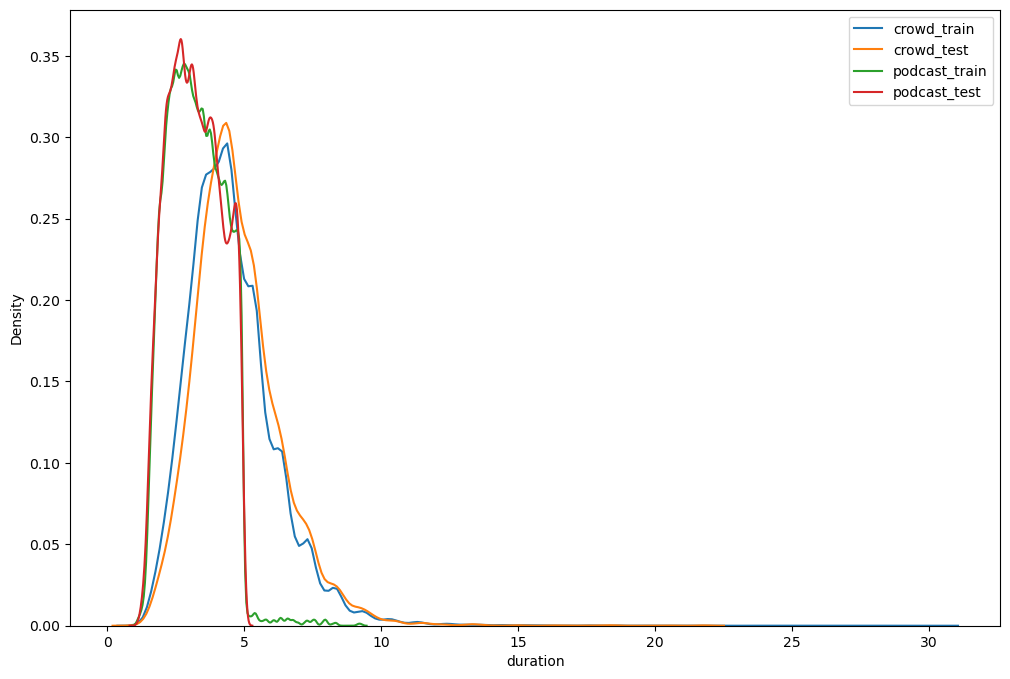

In [252]:
plt.figure(figsize=(12, 8))
sns.distplot(crowd_train['duration'], label='crowd_train', hist=False)
sns.distplot(crowd_test['duration'], label='crowd_test', hist=False)
sns.distplot(podcast_train['duration'], label='podcast_train', hist=False)
sns.distplot(podcast_test['duration'], label='podcast_test', hist=False)
plt.legend()

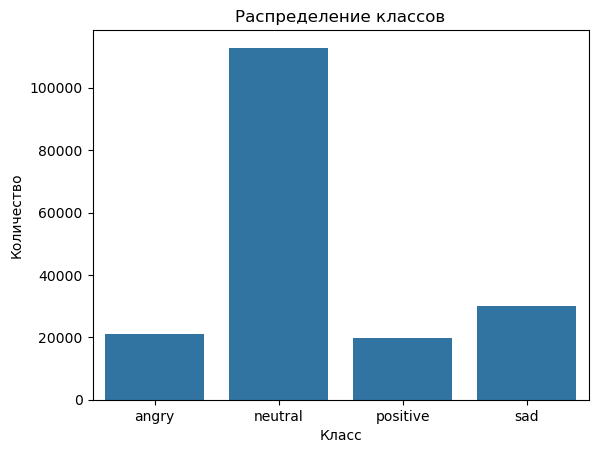

In [253]:
sns.countplot(x='annotator_emo', data=crowd_train)

plt.xlabel('Класс')
plt.ylabel('Количество')
plt.title('Распределение классов')

plt.show()

In [254]:
crowd_train['annotator_emo'].value_counts()

annotator_emo
neutral     112818
sad          29940
angry        21071
positive     19837
Name: count, dtype: int64

### Sample

In [256]:
waveform, sample_rate = torchaudio.load('crowd_train/wavs/593277832bed252bf5f321223d5d08f4.wav')
waveform[0].shape, sample_rate

(torch.Size([53584]), 16000)

In [257]:
import wave

with wave.open(r'crowd_train/wavs/7f8cfd19f860eff13b2a9cad8b01973f.wav', "rb") as wave_file:
    SAMPLE_RATE = wave_file.getframerate()
    print(f"Sample rate: {SAMPLE_RATE}")

Sample rate: 16000


In [258]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(10, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz', cmap='magma')
    plt.colorbar()

def create_mfcc(data, sr, e):
    plt.figure(figsize=(11, 3))
    mfcc = librosa.feature.mfcc(y=data, sr=sr, hop_length = 512, n_mfcc=13)
    librosa.display.specshow(mfcc, x_axis='time')
    plt.ylabel('MFCC')
    plt.colorbar()
    plt.show()
    plt.plot(np.mean(mfcc.T, axis=0))
    plt.show()
    return mfcc

/Users/kirillanpilov/NLP_FU/Lab6/crowd_train/wavs/1b8c3332e12063486015a563cf7355fe.wav


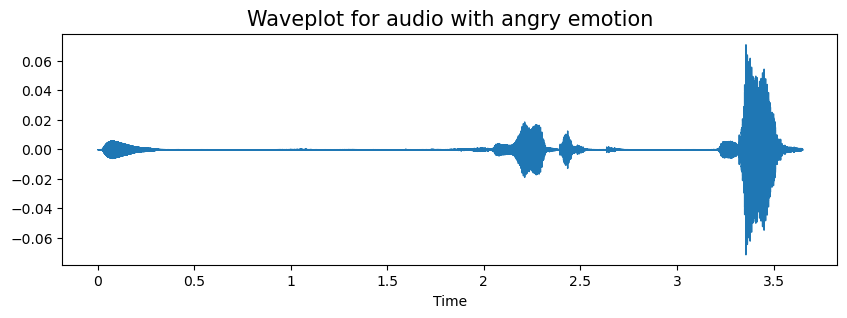

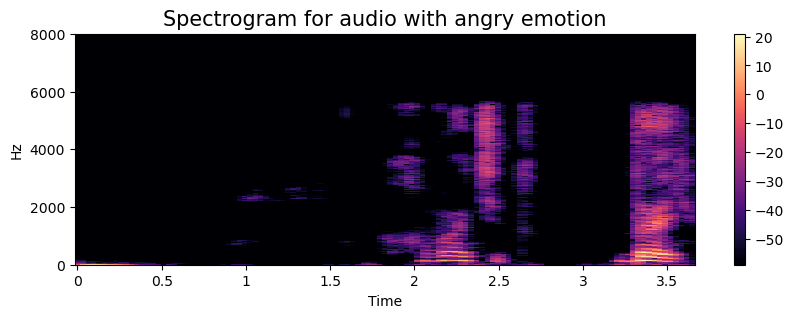

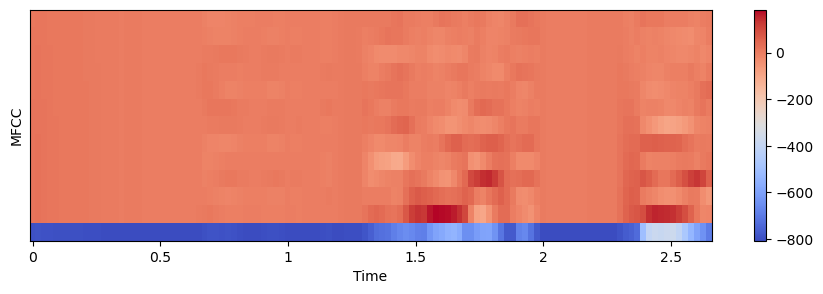

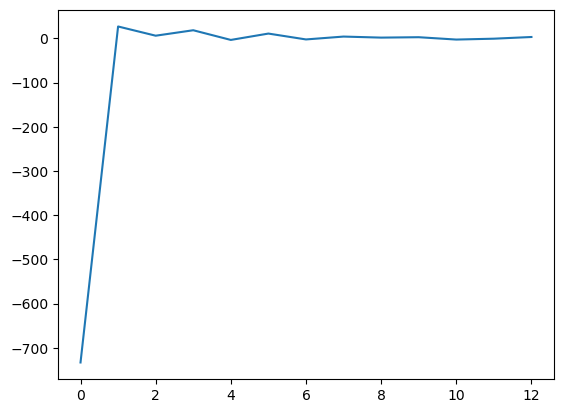

In [259]:
emo = 'angry'
path = "/Users/kirillanpilov/NLP_FU/Lab6/crowd_train/wavs/" + crowd_train[crowd_train['annotator_emo'] == emo]['audio_path'].iloc[3]
print(path)
data, sr = librosa.load(path)
data = nr.reduce_noise(data, sr=sr)
xt, index = librosa.effects.trim(data, top_db=33)
display(Audio(xt, rate=sr))
create_waveplot(xt, sampling_rate, emo)
create_spectrogram(xt, sampling_rate, emo)
mfcc_p = create_mfcc(xt, sampling_rate, emo)
#Audio(path)

Text(0.5, 1.0, 'Mean MFCC на Crowd, после предобработки')

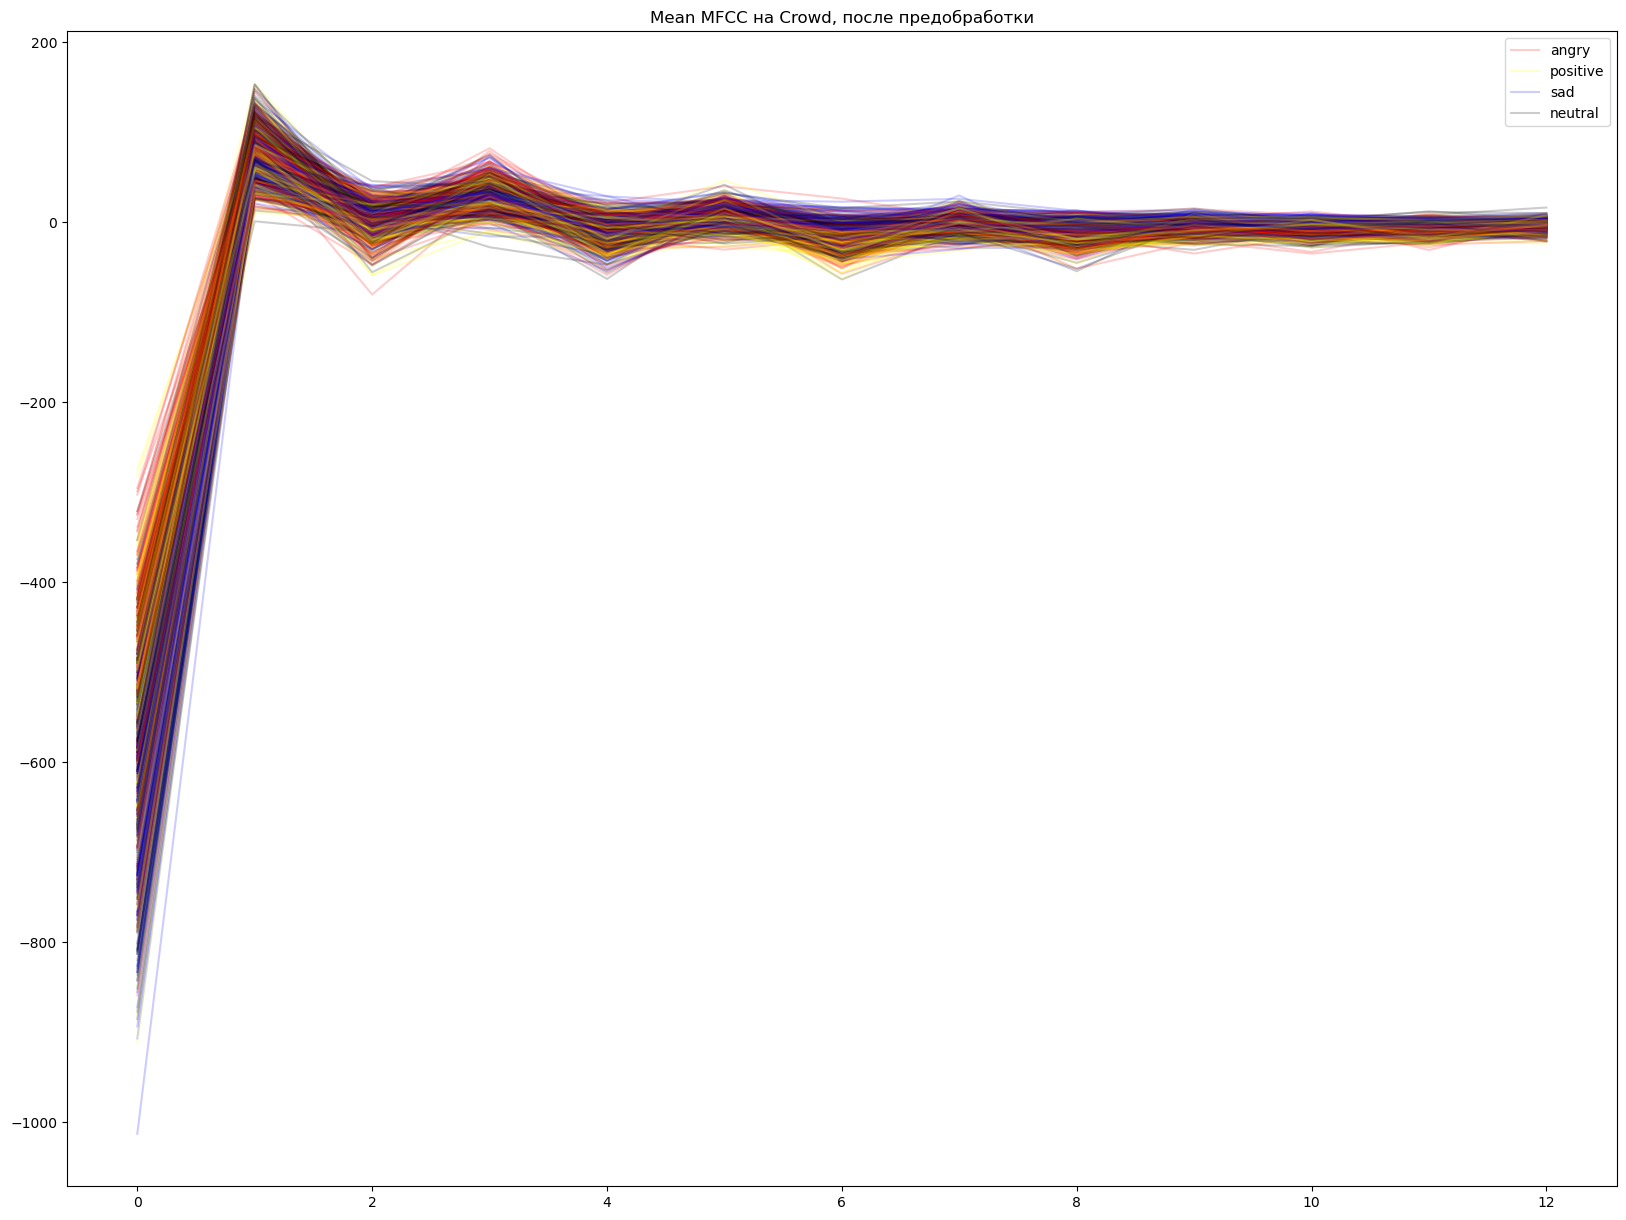

In [260]:
plt.figure(figsize=(20, 15))
colors = ['', 'black', 'yellow', 'blue', '', 'red']
for i in range(200):
    for emo in ['angry', 'positive', 'sad', 'neutral']:
        path = "/Users/kirillanpilov/NLP_FU/Lab6/crowd_train/wavs/" + crowd_train[crowd_train['annotator_emo'] == emo]['audio_path'].iloc[i]
        data, sr = librosa.load(path)
        data = nr.reduce_noise(data, sr=sr)
        data, index = librosa.effects.trim(data, top_db=33)
        mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sr, hop_length = 512, n_mfcc=13), axis=1)
        if i==0:
            plt.plot(mfcc, color=colors[len(emo)%6], alpha=0.2, label=emo)
        else:
            plt.plot(mfcc, color=colors[len(emo)%6], alpha=0.2)
plt.legend()
plt.title('Mean MFCC на Crowd, после предобработки')